# Indoor Temperature-Based Hysteresis Control

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('simulation_results_finished.csv')
outdoor_temp_series = df['Dry-bulb temperature (°C)']

In [3]:
# Function to calculate heat loss
def calculate_heat_loss(K, indoor_temp, outdoor_temp):
    return K * (indoor_temp - outdoor_temp)

In [4]:
# Define constants
desired_indoor_temp = 20.0  # Desired indoor temperature in °C
lower_threshold = 19.0      # Lower temperature threshold to turn on the heat pump
upper_threshold = 21.0      # Upper temperature threshold to turn off the heat pump

# Heat loss coefficient
K_SH = 0.02

# Time step in hours
delta_t = 0.5

# Building conditions
rho_in = 1.2041  # Air density in kg/m^3
c_in = 1000      # Specific heat capacity of air in J/(kg*K)
V_in = 3277      # Volume of the building in m^3

In [5]:
# Initialize variables
heat_demand_profile = []
heat_pump_status = []

indoor_temp = lower_threshold
indoor_temp_series = []



# Hysteresis control loop over time
for outdoor_temp in outdoor_temp_series:
    
    if outdoor_temp >= desired_indoor_temp:
        heat_pump_status.append("Off")
        heat_demand = 0
        indoor_temp = upper_threshold
        indoor_temp_series.append(indoor_temp)
    else:
        
        indoor_temp_series.append(indoor_temp)
        
        if indoor_temp <= lower_threshold:
            # Temperature below lower threshold - turn on the heat pump
            heat_pump_status.append("On")
            heat_demand = (calculate_heat_loss(K_SH, indoor_temp, outdoor_temp))/delta_t
            indoor_temp = desired_indoor_temp
        elif indoor_temp >= upper_threshold:
            # Temperature above upper threshold - turn off the heat pump
            heat_pump_status.append("Off")
            indoor_temp -= (calculate_heat_loss(K_SH, indoor_temp, outdoor_temp)*3.6e6)/(rho_in*V_in*c_in)
            heat_demand = 0
        else:
            # Temperature within the hysteresis band - keep the heat pump in its current state
            heat_pump_status.append(heat_pump_status[-1])
            if heat_pump_status[-1] == "On":
                    
                heat_demand = (calculate_heat_loss(K_SH, indoor_temp, outdoor_temp))/delta_t
                indoor_temp = upper_threshold
            else:
                indoor_temp -= (calculate_heat_loss(K_SH, indoor_temp, outdoor_temp)*3.6e6)/(rho_in*V_in*c_in)
                heat_demand = 0
    
    heat_demand_profile.append(heat_demand)


In [6]:
# Create a DataFrame for visualization
simulation_data = pd.DataFrame({
    "Date": df['Date'],
    "Outdoor Temperature (°C)": outdoor_temp_series,
    "Indoor Temperature (°C)": indoor_temp_series,
    "Heat Demand (kW)": heat_demand_profile,
    "Heat Pump Status": heat_pump_status
})

In [7]:
simulation_data['Heat Demand (kWh)'] = simulation_data['Heat Demand (kW)'] * delta_t
simulation_data.to_csv("simulation_results_hysteresis.csv", index=False)

# Visualisation

In [8]:
simulation_data['Date'] = pd.to_datetime(simulation_data['Date'], format='%Y-%m-%d %H:%M:%S')
simulation_data.set_index('Date', inplace=True)

In [9]:
simulation_data.head()

,Outdoor Temperature (°C),Indoor Temperature (°C),Heat Demand (kW),Heat Pump Status,Heat Demand (kWh)
Date,,,,,
2023-01-01 00:00:00,5.5,19.000000,0.54,On,0.27
2023-01-01 00:30:00,5.5,20.000000,0.58,On,0.29
2023-01-01 01:00:00,5.5,21.000000,0.00,Off,0.00
2023-01-01 01:30:00,5.5,20.717170,0.00,Off,0.00
2023-01-01 02:00:00,5.5,20.439501,0.00,Off,0.00


## Annual half hourly profile

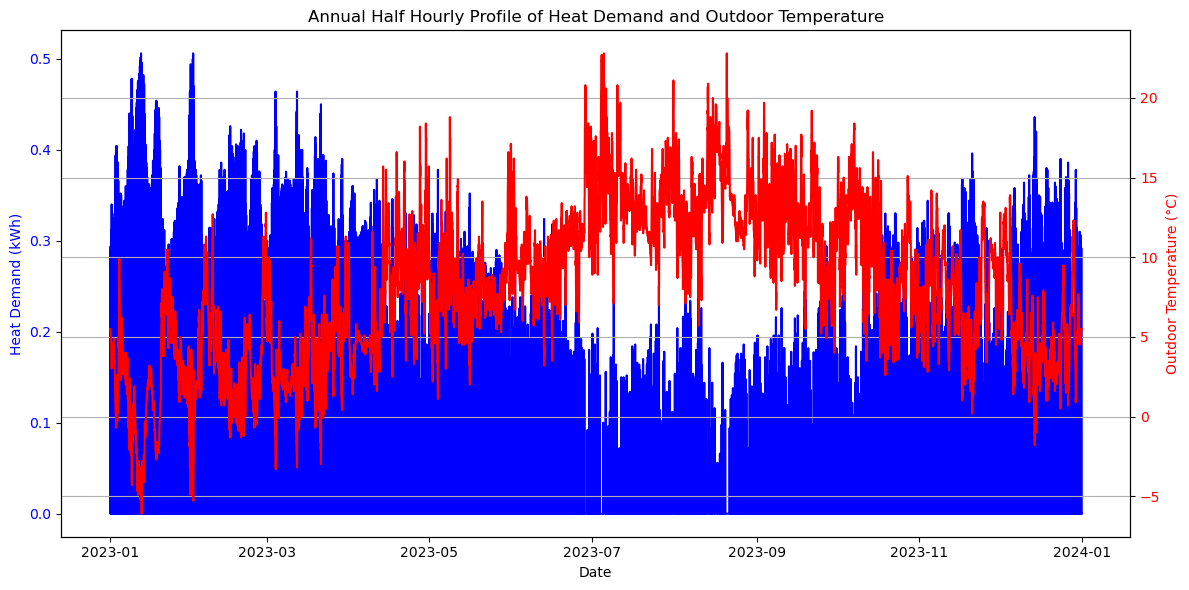

In [10]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heating Demand on the first y-axis
ax1.plot(simulation_data.index, simulation_data['Heat Demand (kWh)'], label='Hourly Heating Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(simulation_data.index, simulation_data['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Annual Half Hourly Profile of Heat Demand and Outdoor Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_half_hourly_profile_hysteresis.pdf')
plt.show()


## Annual hourly profile

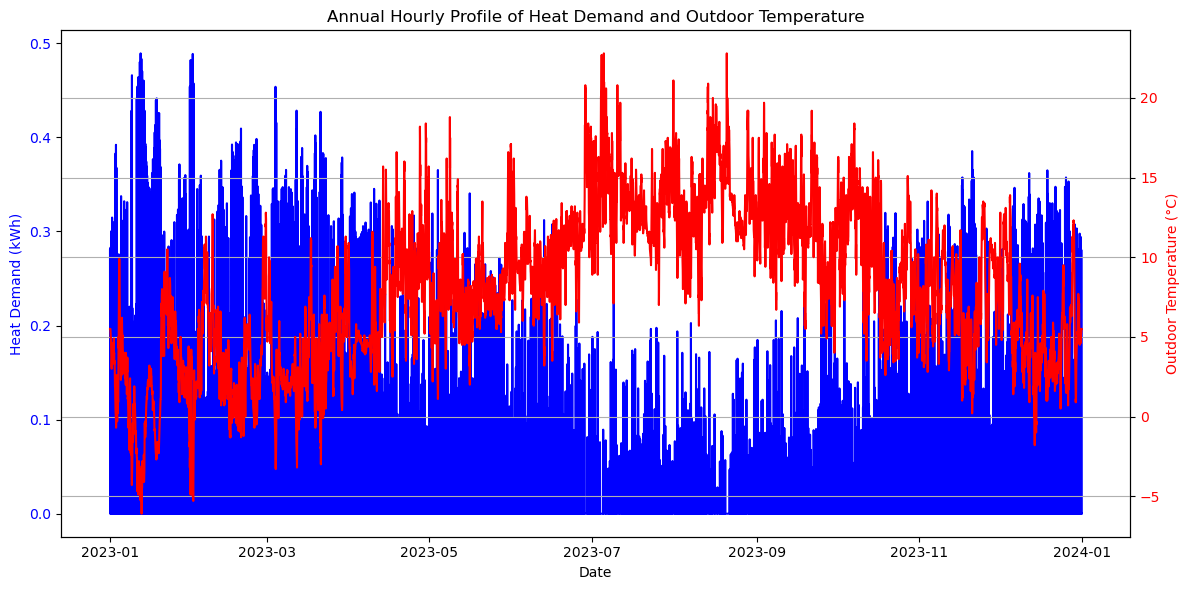

In [11]:
# Resample to hourly frequency and calculate the mean
numeric_df = simulation_data.select_dtypes(include='number')
hourly_df = numeric_df.resample('h').mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heating Demand on the first y-axis
ax1.plot(hourly_df.index, hourly_df['Heat Demand (kWh)'], label='Hourly Heating Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(hourly_df.index, hourly_df['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Annual Hourly Profile of Heat Demand and Outdoor Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_hourly_profile_hysteresis.pdf')
plt.show()

## Daily hourly profile

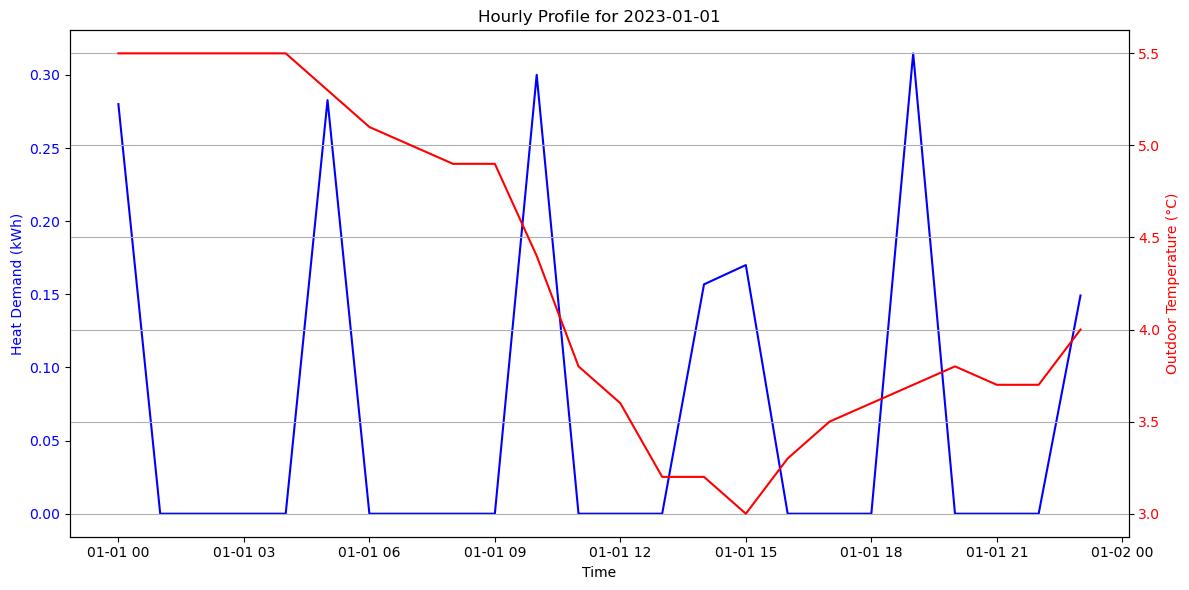

In [12]:
# Specify the day you want to plot
specific_day = '2023-01-01'  # Change this to the desired date

# Filter the data for the specific day
daily_profile = hourly_df.loc[specific_day]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heating Demand on the first y-axis
ax1.plot(daily_profile.index, daily_profile['Heat Demand (kWh)'], label='Hourly Heat Demand', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(daily_profile.index, daily_profile['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title(f'Hourly Profile for {specific_day}')
fig.tight_layout()
plt.grid()
plt.savefig(f'./figures/hourly_profile_{specific_day}_hysteresis.pdf')
plt.show()

## Annual daily profile

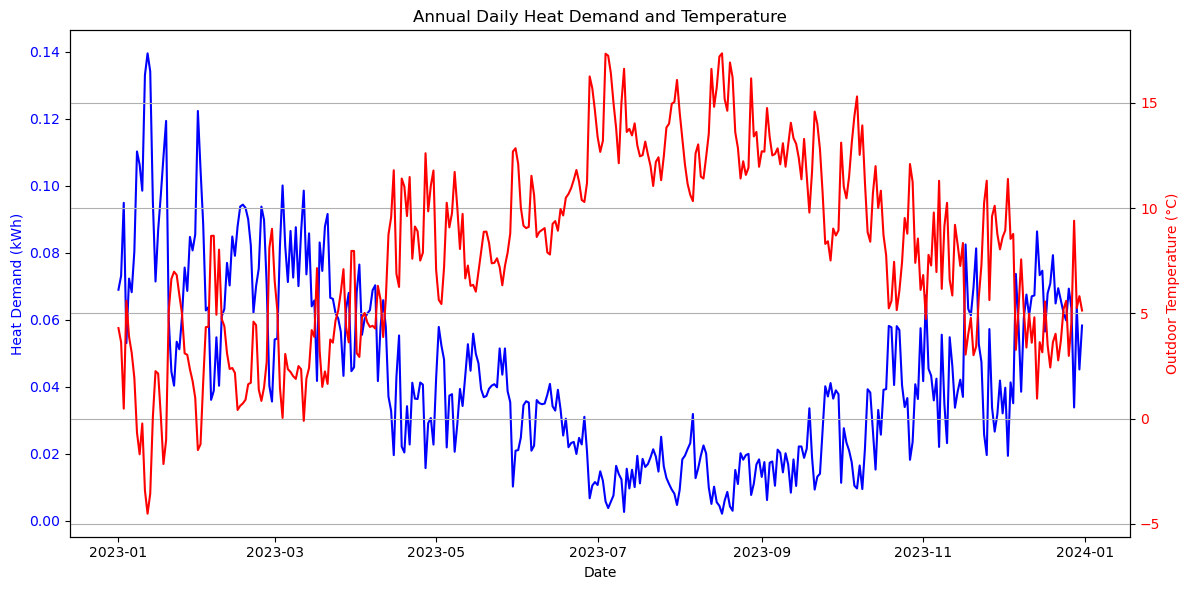

In [13]:
daily_df = numeric_df.resample('D').mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heating Demand on the first y-axis
ax1.plot(daily_df.index, daily_df['Heat Demand (kWh)'], label='Hourly Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(daily_df.index, daily_df['Outdoor Temperature (°C)'], label='Hourly Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Annual Daily Heat Demand and Temperature')
fig.tight_layout()
plt.grid()
plt.savefig('./figures/annual_daily_profile_hysteresis.pdf')
plt.show()

## Monthly daily profile

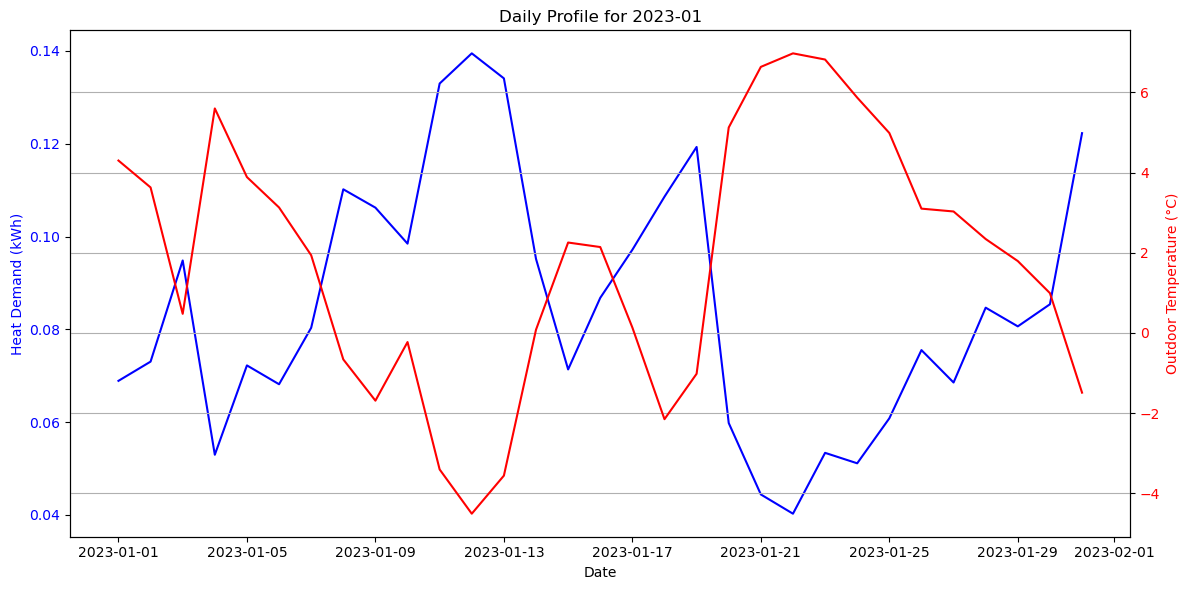

In [14]:
# Specify the month you want to plot
specific_month = '2023-01'  # Change this to the desired month

# Filter the data for the specific month
monthly_profile = daily_df.loc[specific_month]

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Heating Demand on the first y-axis
ax1.plot(monthly_profile.index, monthly_profile['Heat Demand (kWh)'], label='Daily Heat Demand', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Heat Demand (kWh)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(monthly_profile.index, monthly_profile['Outdoor Temperature (°C)'], label='Daily Temperature', color='red')
ax2.set_ylabel('Outdoor Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title(f'Daily Profile for {specific_month}')
fig.tight_layout()
plt.grid()
plt.savefig(f'./figures/monthly_profile_{specific_month}_hysteresis.pdf')
plt.show()